In [67]:
import sys, pathlib
# Go from .../crypto/markov -> .../cooking_polymarket2
PROJECT_ROOT = pathlib.Path().resolve().parents[1]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(PROJECT_ROOT)



import time
import numpy as np
import pandas as pd
from crypto.api.binance import fetch_candles, klines_to_df, compute_log_returns, LIMIT

def get_last_disjoint_minute_candle_series(n: int, m: int, include_log_returns: bool = False, as_numpy: bool = False, add_delta: bool = False):
    """
    Fetch the n most recent disjoint sequences of length m made of 1-minute BTCUSDT candles.

    This reuses [fetch_candles](cci:1://file:///home/dani/projects/polymarket/cooking_polymarket2/crypto/api/binance.py:60:0-74:22) and [klines_to_df](cci:1://file:///home/dani/projects/polymarket/cooking_polymarket2/crypto/api/binance.py:77:0-86:37) in this module.

    Args:
        n: Number of disjoint sequences to return.
        m: Number of candles per sequence.
        include_log_returns: If True and as_numpy is False, adds a 'log_return' column to each DataFrame.
                             Note: each sequence will then have length m-1 due to differencing.
        as_numpy: If True, returns a numpy array of closes with shape (n, m).
                  If False, returns a list of DataFrames with columns ['open_time', 'close']
                  (and 'log_return' if requested).

    Returns:
        np.ndarray | list[pd.DataFrame]

    Raises:
        ValueError: if n or m are non-positive, or if insufficient candles are returned by Binance.
    """
    if n <= 0 or m <= 0:
        raise ValueError("n and m must be positive integers.")

    total_needed = n * m
    all_klines = []
    end_time = int(time.time() * 1000)

    while len(all_klines) < total_needed:
        batch_limit = min(LIMIT, total_needed - len(all_klines))
        klines = fetch_candles(limit=batch_limit, endTime=end_time)
        if not klines:
            break
        # Prepend older klines so that the list stays chronological
        all_klines = klines + all_klines
        # Next batch: go strictly before the earliest kline we just received
        end_time = klines[0][0] - 1
        time.sleep(0.2)

    if len(all_klines) < total_needed:
        raise ValueError(f"Insufficient candles fetched: requested {total_needed}, got {len(all_klines)}")

    # Keep exactly the last total_needed candles
    all_klines = all_klines[-total_needed:]
    full_df = klines_to_df(all_klines)

    if as_numpy:
        # Return closes only, shape (n, m), ordered from most recent chunk to oldest
        return np.stack([
            full_df.iloc[len(full_df) - (i + 1) * m: len(full_df) - i * m]['close'].astype(float).to_numpy()
            for i in range(n)
        ], axis=0)

    # Otherwise return list of DataFrames
    series_list = []
    for i in range(n):
        start = len(full_df) - (i + 1) * m
        end = len(full_df) - i * m
        seg = full_df.iloc[start:end].reset_index(drop=True).copy()
        if include_log_returns:
            seg = compute_log_returns(seg)
        series_list.append(seg)
    
    if add_delta:
        for series in series_list:
            series['delta'] = series['close'].diff()
            #drop NaN at the 0 position
            series = series.dropna()

    return series_list




/home/dani/projects/polymarket/cooking_polymarket2


In [68]:
series = get_last_disjoint_minute_candle_series(n=1, m=60, add_delta=True)


In [69]:
series[0].tail()

,open_time,close,delta
55,2025-10-24 17:27:00,110455.73,-55.66
56,2025-10-24 17:28:00,110494.37,38.64
57,2025-10-24 17:29:00,110493.25,-1.12
58,2025-10-24 17:30:00,110433.65,-59.60
59,2025-10-24 17:31:00,110433.66,0.01


# Histogram minute changes

In [70]:
N = 10000
series = get_last_disjoint_minute_candle_series(n=1, m=N, add_delta=True)[0].iloc[1:-1]
series.tail()

,open_time,close,delta
9994,2025-10-24 17:26:00,110511.39,-58.61
9995,2025-10-24 17:27:00,110455.73,-55.66
9996,2025-10-24 17:28:00,110494.37,38.64
9997,2025-10-24 17:29:00,110493.25,-1.12
9998,2025-10-24 17:30:00,110433.65,-59.60


In [71]:

try:
    import seaborn as sns
    _HAS_SNS = True
except ImportError:
    _HAS_SNS = False


def summarize_minute_changes(
    data,
    column: str = "delta",
    lags: int = 60,
    bins="fd",
    clip_std: float | None = None,
    title: str | None = None,
    show: bool = True,
):
    """
    Summarize a minute-to-minute changes series.

    - Plots histogram (+ KDE if seaborn is available), marking mean and median.
    - Prints min, max, mean, median, std.
    - Plots Pearson time-lag correlation (ACF) up to `lags` minutes with 95% CI bands.

    Args:
        data: pandas Series or DataFrame. If DataFrame, looks for `column`. If `column`
              is not present but `close` is, will use close.diff() as a fallback.
        column: column name for the change series (default 'delta').
        lags: max time lag (in minutes) for ACF.
        bins: histogram bins (e.g., 'fd', 'auto', integer).
        clip_std: if provided, winsorizes values to mean ± clip_std * std before plotting.
        title: optional figure title.
        show: whether to call plt.show(). Returns figure and stats either way.

    Returns:
        {
          'stats': {min, max, mean, median, std, count},
          'acf': np.ndarray of shape (lags,),
          'series': pd.Series used,
          'fig': matplotlib.figure.Figure
        }
    """
    # Resolve to a float series
    if isinstance(data, pd.DataFrame):
        if column in data.columns:
            s = pd.to_numeric(data[column], errors="coerce")
        elif "close" in data.columns:
            s = pd.to_numeric(data["close"], errors="coerce").diff()
        else:
            raise ValueError(f"DataFrame must contain '{column}' or 'close' column.")
    else:
        s = pd.Series(data, dtype="float64")

    s = s.dropna().astype(float)
    n = len(s)
    if n == 0:
        raise ValueError("Series is empty after dropping NaNs.")

    # Optional winsorization
    if clip_std is not None and clip_std > 0:
        mu = s.mean()
        sd = s.std(ddof=1)
        s = s.clip(lower=mu - clip_std * sd, upper=mu + clip_std * sd)

    # Stats
    stats = {
        "count": int(n),
        "min": float(s.min()),
        "max": float(s.max()),
        "mean": float(s.mean()),
        "median": float(s.median()),
        "std": float(s.std(ddof=1)),
    }

    print(
        f"count: {stats['count']}\n"
        f"min:   {stats['min']:.6f}\n"
        f"max:   {stats['max']:.6f}\n"
        f"mean:  {stats['mean']:.6f}\n"
        f"median:{stats['median']:.6f}\n"
        f"std:   {stats['std']:.6f}"
    )

    # Figure layout: histogram (top), ACF (bottom)
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.35)
    ax_hist = fig.add_subplot(gs[0])
    ax_acf = fig.add_subplot(gs[1])

    # Histogram
    if _HAS_SNS:
        sns.histplot(s, bins=bins, kde=True, stat="density", color="tab:blue",
                     edgecolor="white", alpha=0.85, ax=ax_hist)
    else:
        ax_hist.hist(s, bins=bins, color="tab:blue", edgecolor="white", alpha=0.85, density=True)

    ax_hist.axvline(stats["mean"], color="red", linestyle="--", linewidth=1.2, label=f"mean={stats['mean']:.4f}")
    ax_hist.axvline(stats["median"], color="green", linestyle=":", linewidth=1.2, label=f"median={stats['median']:.4f}")
    ax_hist.set_xlabel(column)
    ax_hist.set_ylabel("Density")
    ax_hist.legend(loc="upper right")
    ax_hist.set_title(title or "Minute-to-minute changes distribution")

    # Pearson time-lag correlation (ACF)
    lags = int(lags)
    acf_vals = np.array([s.autocorr(lag) for lag in range(1, lags + 1)]) if lags > 0 else np.array([])
    conf = 1.96 / np.sqrt(n)  # Approx 95% CI for no autocorrelation

    if lags > 0:
        ax_acf.bar(np.arange(1, lags + 1), acf_vals, color="tab:orange")
        ax_acf.axhline(0, color="black", linewidth=1)
        ax_acf.axhline(conf, color="gray", linestyle="--", linewidth=1)
        ax_acf.axhline(-conf, color="gray", linestyle="--", linewidth=1)
        ax_acf.set_xlabel("Lag (minutes)")
        ax_acf.set_ylabel("Pearson r")
        ax_acf.set_title(f"Pearson time-lag correlation (ACF) up to {lags} lags")

    if show:
        plt.show()

    return {"stats": stats, "acf": acf_vals, "series": s, "fig": fig}

count: 9998
min:   -325.040501
max:   325.808347
mean:  0.428533
median:0.000000
std:   60.585226


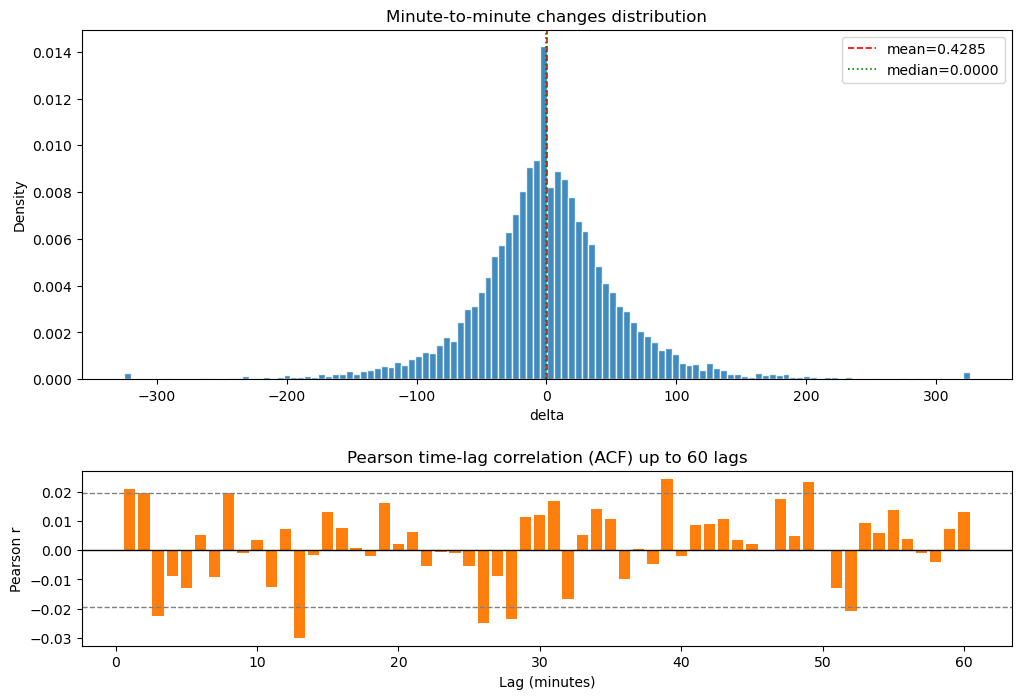

In [72]:
summary = summarize_minute_changes(series, column="delta", lags=60, bins="fd", clip_std=5)


In [73]:
import pandas as pd

def hourly_delta_series(
    df: pd.DataFrame,
    time_col: str = "open_time",
    delta_col: str = "delta",
    tz: str | None = None,
    require_full_hours: bool = False,
    label: str = "left",   # "left" = hour labeled by its start, "right" = by its end
    closed: str = "left",  # interval closure; typically "left" pairs with label="left"
) -> pd.Series:
    """
    Aggregate minute deltas to hourly deltas with full-hour timestamps.

    Args:
        df: DataFrame with time and minute delta columns.
        time_col: name of the datetime column (minute frequency).
        delta_col: name of the minute-to-minute delta column to sum.
        tz: optional timezone. If provided, localizes (if naive) or converts (if tz-aware).
        require_full_hours: if True, keep only hours with exactly 60 minute observations.
        label: resample label ("left" or "right").
        closed: resample closed side ("left" or "right").

    Returns:
        pd.Series indexed by hourly timestamps, named 'hourly_delta'.
    """
    if time_col not in df.columns or delta_col not in df.columns:
        raise ValueError(f"Expected columns '{time_col}' and '{delta_col}'")

    s = df[[time_col, delta_col]].copy()
    s[time_col] = pd.to_datetime(s[time_col], errors="coerce")
    s = s.dropna(subset=[time_col, delta_col])

    s = s.set_index(time_col).sort_index()

    # Optional timezone handling
    if tz is not None:
        if s.index.tz is None:
            s.index = s.index.tz_localize(tz)
        else:
            s.index = s.index.tz_convert(tz)

    resampler = s[delta_col].resample("H", label=label, closed=closed)

    hourly_sum = resampler.sum().rename("hourly_delta")

    if require_full_hours:
        counts = resampler.count()
        hourly_sum = hourly_sum[counts.eq(60)]

    return hourly_sum

In [74]:
# extract full hour information
series_full_hourly = hourly_delta_series(series)

/tmp/ipykernel_394611/1927310066.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampler = s[delta_col].resample("H", label=label, closed=closed)


In [75]:
series_full_hourly.tail(5)

open_time
2025-10-24 13:00:00   -359.07
2025-10-24 14:00:00   -718.77
2025-10-24 15:00:00   -172.26
2025-10-24 16:00:00    214.90
2025-10-24 17:00:00    171.84
Freq: h, Name: hourly_delta, dtype: float64

In [76]:
len(series_full_hourly)

168

count: 168
min:   -1749.340000
max:   3743.540000
mean:  22.847976
median:8.205000
std:   521.927855


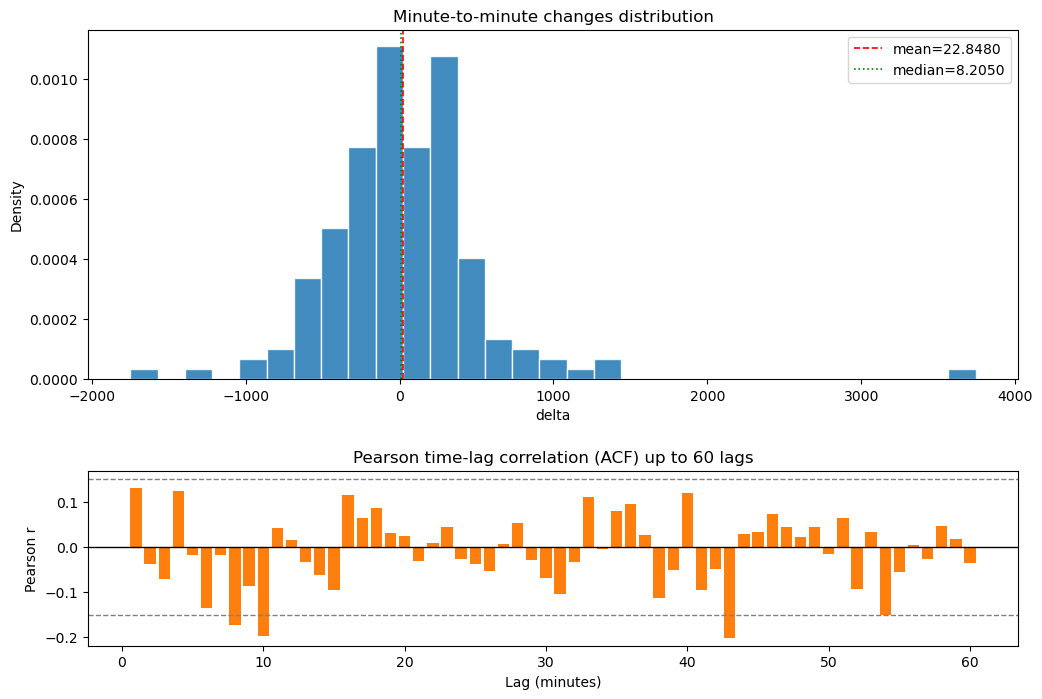

{'stats': {'count': 168,
  'min': -1749.340000000011,
  'max': 3743.540000000008,
  'mean': 22.847976190476142,
  'median': 8.205000000001746,
  'std': 521.9278547232369},
 'acf': array([ 0.13134302, -0.03687196, -0.07121294,  0.12487029, -0.01827365,
        -0.13538942, -0.01694002, -0.17435992, -0.08730535, -0.19687659,
         0.0416811 ,  0.01649699, -0.03286738, -0.06308124, -0.09625274,
         0.11470683,  0.06426966,  0.08618419,  0.03089263,  0.02355351,
        -0.03067406,  0.0097333 ,  0.04493717, -0.02732843, -0.03748176,
        -0.05231071,  0.00598381,  0.05283176, -0.02835652, -0.06876528,
        -0.10507906, -0.03433738,  0.11005991, -0.00434332,  0.0792716 ,
         0.09465458,  0.02770969, -0.11235287, -0.05084231,  0.11917791,
        -0.09601253, -0.04781791, -0.20167633,  0.02986303,  0.03221137,
         0.07311791,  0.04451726,  0.02147056,  0.04516192, -0.01601265,
         0.06465553, -0.09438574,  0.03408253, -0.15203331, -0.05510527,
         0.0045040

In [77]:
summarize_minute_changes(series_full_hourly)

In [78]:

try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

from scipy import stats


def analyze_distribution_fit(
    data,
    bins="fd",
    max_bins=200,
    candidate_models=("norm", "t", "laplace", "cauchy", "skewnorm"),
    clip_std=None,
    show=True,
    random_subset=None,
    fig_size=(13, 9),
    title=None,
    # New controls:
    plot_top_k=2,
    ranking_metric="bic",  # one of {"bic", "chi2", "kl"}; lower is better
):
    """
    Assess skew/shift/asymmetry and fit multiple distributions to find the closest model.
    Plots only the top-k models (default 2) by the chosen ranking metric in the histogram.

    Args:
        data: 1D array-like (NaNs dropped).
        bins: histogram bins for plotting and binned metrics.
        max_bins: cap the number of bins if 'fd'/'auto' yields too many.
        candidate_models: ('norm','t','laplace','cauchy','skewnorm').
        clip_std: clip to mean ± clip_std * std prior to fitting/plotting.
        show: whether to display plots.
        random_subset: subsample size for speed if data is huge.
        fig_size: figure size.
        title: optional title.
        plot_top_k: number of best models to overlay on the histogram.
        ranking_metric: which score to rank by: "bic" (default), "chi2", or "kl".

    Returns:
        dict with 'stats', 'fits' (DataFrame), best-by metrics, histogram info, and figure.
    """
    # 1) Clean and optionally downsample
    x = pd.Series(data, dtype="float64").dropna().to_numpy()
    n_full = len(x)
    if n_full == 0:
        raise ValueError("Empty data after dropping NaNs.")
    if clip_std is not None and clip_std > 0:
        mu, sd = np.mean(x), np.std(x, ddof=1)
        x = np.clip(x, mu - clip_std * sd, mu + clip_std * sd)
    if random_subset is not None and isinstance(random_subset, int) and random_subset < len(x):
        rng = np.random.default_rng(42)
        x = rng.choice(x, size=random_subset, replace=False)

    n = len(x)
    eps = 1e-14

    # 2) Descriptive metrics
    mean = float(np.mean(x))
    median = float(np.median(x))
    std = float(np.std(x, ddof=1))
    fisher_skew = float(stats.skew(x, bias=False))
    pearson2 = float(3.0 * (mean - median) / (std if std > 0 else 1.0))
    q1, q2, q3 = np.quantile(x, [0.25, 0.5, 0.75])
    bowley = float(((q3 + q1) - 2 * q2) / (q3 - q1)) if (q3 - q1) > 0 else np.nan
    q10, q90 = np.quantile(x, [0.10, 0.90])
    left_tail = max(median - q10, eps)
    right_tail = max(q90 - median, eps)
    tail_asym_ratio = float(right_tail / left_tail)

    desc_stats = {
        "n": int(n),
        "n_full": int(n_full),
        "mean": mean,
        "median": median,
        "std": std,
        "fisher_skew": fisher_skew,
        "pearson2_skew": pearson2,
        "bowley_skew": bowley,
        "tail_asym_ratio_90_10": tail_asym_ratio,
        "q10": float(q10),
        "q90": float(q90),
    }

    # 3) Histogram for binned metrics
    counts, edges = np.histogram(x, bins=bins)
    if isinstance(bins, (str, np.integer)) and len(counts) > max_bins:
        counts, edges = np.histogram(x, bins=min(max_bins, len(counts)))
    widths = np.diff(edges)
    centers = edges[:-1] + widths / 2
    probs_emp = counts / max(counts.sum(), 1)

    # 4) Fit candidate models
    dist_map = {
        "norm": stats.norm,
        "t": stats.t,
        "laplace": stats.laplace,
        "cauchy": stats.cauchy,
        "skewnorm": stats.skewnorm,
    }

    fit_rows = []
    for name in candidate_models:
        if name not in dist_map:
            continue
        dist = dist_map[name]
        try:
            params = dist.fit(x)
            k = len(params)
            pdf_vals = np.maximum(dist.pdf(x, *params), eps)
            loglik = float(np.sum(np.log(pdf_vals)))
            aic = 2 * k - 2 * loglik
            bic = k * np.log(n) - 2 * loglik

            cdf_lo = dist.cdf(edges[:-1], *params)
            cdf_hi = dist.cdf(edges[1:], *params)
            p_model = np.clip(cdf_hi - cdf_lo, eps, 1.0)
            exp_counts = p_model * counts.sum()

            chi2 = float(np.sum((counts - exp_counts) ** 2 / np.maximum(exp_counts, eps)))
            kl = float(np.sum(probs_emp * (np.log(np.maximum(probs_emp, eps)) - np.log(p_model))))

            fit_rows.append({
                "model": name,
                "params": params,
                "k": k,
                "loglik": loglik,
                "aic": aic,
                "bic": bic,
                "chi2": chi2,
                "kl": kl,
            })
        except Exception as e:
            fit_rows.append({
                "model": name,
                "params": None,
                "k": np.nan,
                "loglik": -np.inf,
                "aic": np.inf,
                "bic": np.inf,
                "chi2": np.inf,
                "kl": np.inf,
                "error": str(e),
            })

    fits_df = pd.DataFrame(fit_rows).set_index("model").sort_values("bic")

    # 5) Winners
    best_by_bic = fits_df["bic"].idxmin() if np.isfinite(fits_df["bic"]).any() else None
    best_by_chi2 = fits_df["chi2"].idxmin() if np.isfinite(fits_df["chi2"]).any() else None
    best_by_kl = fits_df["kl"].idxmin() if np.isfinite(fits_df["kl"]).any() else None

    # 6) Plot
    fig = plt.figure(figsize=fig_size)
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 2], width_ratios=[2, 1.5], hspace=0.35, wspace=0.3)

    # Histogram
    ax_hist = fig.add_subplot(gs[:, 0])
    if _HAS_SNS:
        sns.histplot(x, bins=edges, stat="density", kde=True, color="tab:blue", edgecolor="white", alpha=0.7, ax=ax_hist)
    else:
        ax_hist.hist(x, bins=edges, density=True, color="tab:blue", edgecolor="white", alpha=0.7)

    # Only plot top-k models by ranking_metric
    metric = ranking_metric.lower()
    if metric not in {"bic", "chi2", "kl"}:
        raise ValueError("ranking_metric must be one of {'bic','chi2','kl'}")
    valid = fits_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[metric])
    top_models = list(valid.sort_values(metric).head(plot_top_k).index)

    x_grid = np.linspace(edges[0], edges[-1], 1000)
    colors = {
        "norm": "tab:orange",
        "t": "tab:green",
        "laplace": "tab:red",
        "cauchy": "tab:purple",
        "skewnorm": "tab:brown",
    }
    for name in top_models:
        params = fits_df.loc[name, "params"]
        if params is None:
            continue
        dist = dist_map[name]
        y = dist.pdf(x_grid, *params)
        score = fits_df.loc[name, metric]
        ax_hist.plot(x_grid, y, color=colors.get(name, None), lw=1.8, label=f"{name} ({metric} {score:.1f})")

    ax_hist.set_title(title or f"Histogram with top {len(top_models)} fitted PDFs by {metric.upper()}")
    ax_hist.set_xlabel("Value")
    ax_hist.set_ylabel("Density")
    if top_models:
        ax_hist.legend()

    # Q–Q plot for best-by-BIC
    ax_qq = fig.add_subplot(gs[0, 1])
    if best_by_bic is not None and fits_df.loc[best_by_bic, "params"] is not None:
        dist = dist_map[best_by_bic]
        params = fits_df.loc[best_by_bic, "params"]
        probs = (np.arange(1, n + 1) - 0.5) / n
        x_sorted = np.sort(x)
        q_theory = dist.ppf(probs, *params)
        ax_qq.scatter(q_theory, x_sorted, s=10, alpha=0.6, color="tab:gray")
        lims = [np.min([q_theory.min(), x_sorted.min()]), np.max([q_theory.max(), x_sorted.max()])]
        ax_qq.plot(lims, lims, "r--", lw=1)
        ax_qq.set_title(f"Q–Q vs {best_by_bic} (best by BIC)")
        ax_qq.set_xlabel("Theoretical quantiles")
        ax_qq.set_ylabel("Empirical quantiles")
    else:
        ax_qq.axis("off")
        ax_qq.set_title("Q–Q (no best model)")

    # Bar chart of model scores
    ax_scores = fig.add_subplot(gs[1, 1])
    try:
        plot_df = fits_df[["bic", "chi2", "kl"]].copy()
        plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna()
        plot_df.sort_values("bic").plot(kind="barh", ax=ax_scores, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
        ax_scores.set_title("Model scores (lower is better)")
        ax_scores.set_xlabel("Score value")
        ax_scores.set_ylabel("Distribution")
    except Exception:
        ax_scores.axis("off")

    if show:
        plt.show()

    # Print summary
    print("=== Descriptive & Skew/Asymmetry ===")
    for k, v in desc_stats.items():
        if isinstance(v, float):
            print(f"{k:>20}: {v: .6f}")
        else:
            print(f"{k:>20}: {v}")

    print("\n=== Model fit summary (sorted by BIC) ===")
    display_cols = ["loglik", "aic", "bic", "chi2", "kl"]
    try:
        display(fits_df[display_cols].round(3))
    except Exception:
        print(fits_df[display_cols].round(3))

    print(f"\nBest by BIC:   {best_by_bic}")
    print(f"Best by Chi2:  {best_by_chi2}")
    print(f"Best by KL:    {best_by_kl}")

    return {
        "stats": desc_stats,
        "fits": fits_df,
        "best_by_bic": best_by_bic,
        "best_by_chi2": best_by_chi2,
        "best_by_kl": best_by_kl,
        "hist": {"counts": counts, "edges": edges, "centers": centers, "widths": widths},
        "fig": fig,
    }

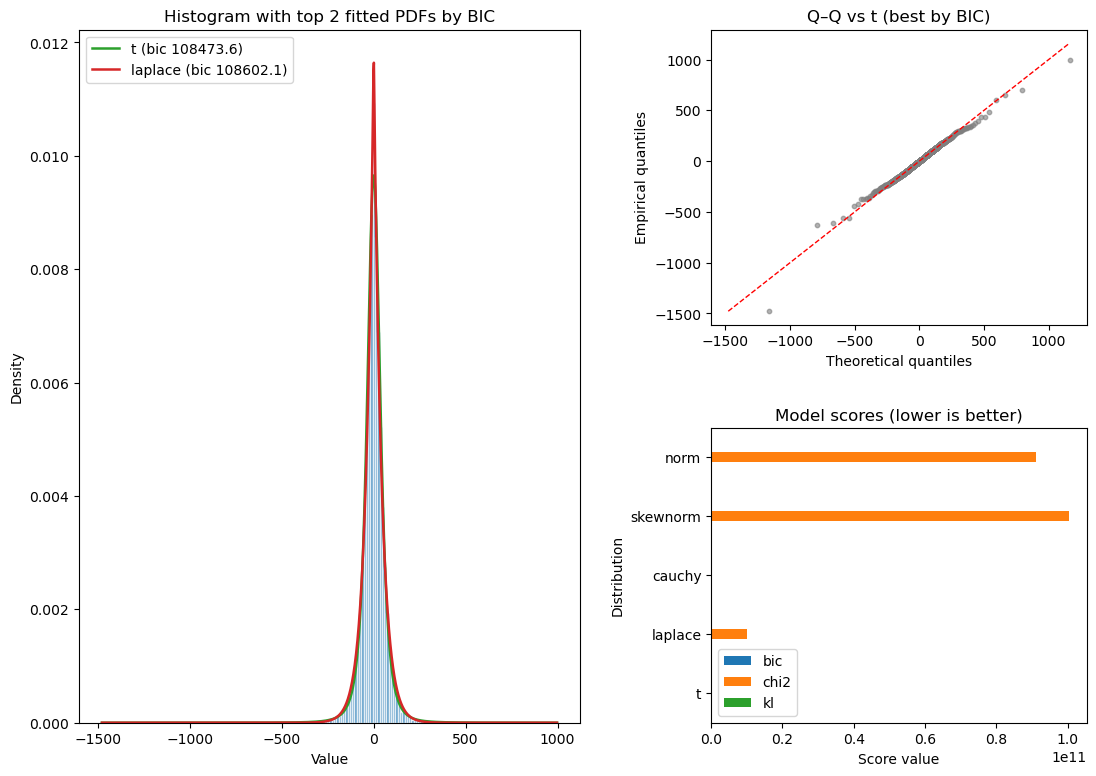

=== Descriptive & Skew/Asymmetry ===
                   n: 9998
              n_full: 9998
                mean:  0.383923
              median:  0.000000
                 std:  65.084885
         fisher_skew: -0.712835
       pearson2_skew:  0.017696
         bowley_skew:  0.013568
tail_asym_ratio_90_10:  1.032699
                 q10: -62.510000
                 q90:  64.554000

=== Model fit summary (sorted by BIC) ===


,loglik,aic,bic,chi2,kl
model,,,,,
t,-54223.004,108452.008,108473.638,3.165100e+02,0.007
laplace,-54291.832,108587.663,108602.084,1.001389e+10,0.016
cauchy,-54961.647,109927.295,109941.715,9.839490e+02,0.080
skewnorm,-55475.417,110956.834,110978.464,1.003508e+11,0.134
norm,-55487.175,110978.351,110992.771,9.117329e+10,0.135



Best by BIC:   t
Best by Chi2:  t
Best by KL:    t


In [79]:
distribution_fit = analyze_distribution_fit(series["delta"])

In [80]:
import numpy as np
import pandas as pd
from typing import Any, Tuple

# Try to use SciPy (recommended)
try:
    from scipy import stats as _sp_stats

    def _std_norm_cdf(z):
        z = np.asarray(z, dtype=float)
        return _sp_stats.norm.cdf(z)

    def _std_norm_sf(z):
        z = np.asarray(z, dtype=float)
        return _sp_stats.norm.sf(z)  # numerically stable for upper tail

    _HAVE_SCIPY = True
except Exception:
    from math import erf as _erf

    # Fallback: vectorize math.erf (slower but correct)
    def _std_norm_cdf(z):
        z = np.asarray(z, dtype=float)
        return 0.5 * (1.0 + np.vectorize(_erf)(z / np.sqrt(2.0)))

    def _std_norm_sf(z):
        z = np.asarray(z, dtype=float)
        return 1.0 - _std_norm_cdf(z)

    _HAVE_SCIPY = False


def _freeze_best_model_from_fit(
    fit_result: dict,
    ranking_metric: str = "bic",  # {"bic","chi2","kl"}
) -> Tuple[str, Any]:
    if "fits" not in fit_result:
        raise ValueError("fit_result must contain key 'fits' (a DataFrame)")

    fits_df = fit_result["fits"]
    metric = ranking_metric.lower()
    if metric not in {"bic", "chi2", "kl"}:
        raise ValueError("ranking_metric must be one of {'bic','chi2','kl'}")

    key_map = {"bic": "best_by_bic", "chi2": "best_by_chi2", "kl": "best_by_kl"}
    preferred = fit_result.get(key_map[metric], None)
    if preferred is None or preferred not in fits_df.index:
        valid = fits_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[metric])
        if valid.empty:
            raise ValueError(f"No valid models found to rank by {metric}")
        preferred = valid.sort_values(metric).index[0]

    if not _HAVE_SCIPY:
        raise RuntimeError("SciPy is required to freeze the best model distribution. Install scipy to proceed.")

    dist_map = {
        "norm": _sp_stats.norm,
        "t": _sp_stats.t,
        "laplace": _sp_stats.laplace,
        "cauchy": _sp_stats.cauchy,
        "skewnorm": _sp_stats.skewnorm,
    }
    if preferred not in dist_map:
        raise ValueError(f"Unsupported best model '{preferred}'")

    params = fits_df.loc[preferred, "params"]
    if params is None:
        raise ValueError(f"Best model '{preferred}' has no fitted params")

    frozen = dist_map[preferred](*params)
    return preferred, frozen


def best_model_hour_finish_probability(
    fit_result: dict,
    current_time: pd.Timestamp | str,
    cum_delta_so_far: float,
    sign: str = "positive",           # "positive", "negative", or "both"
    include_current_minute: bool = True,
    minutes_per_hour: int = 60,
    ranking_metric: str = "bic",
) -> float | dict:
    """
    Probability that the ongoing full hour ends positive/negative using the mean/std
    from the best fitted minute model (from analyze_distribution_fit) and a Gaussian
    approximation for the sum of remaining minutes.
    """
    _, frozen = _freeze_best_model_from_fit(fit_result, ranking_metric=ranking_metric)
    mu = float(frozen.mean())
    sigma = float(frozen.std())

    t = pd.to_datetime(current_time)
    minute_of_hour = int(t.minute)

    k = minute_of_hour + (1 if include_current_minute else 0)
    k = max(0, min(k, minutes_per_hour))
    remaining = minutes_per_hour - k

    # Edge cases
    if remaining <= 0 or sigma <= 0:
        final_value = cum_delta_so_far + remaining * mu
        p_pos = 1.0 if final_value > 0 else (0.5 if final_value == 0 else 0.0)
        p_neg = 1.0 - p_pos if final_value != 0 else 0.5
        return {"positive": p_pos, "negative": p_neg} if sign == "both" else (p_pos if sign == "positive" else p_neg)

    # Gaussian approximation for remaining sum
    m = remaining * mu
    s = np.sqrt(remaining) * sigma
    z = (-cum_delta_so_far - m) / s

    # P(S > -cum_delta_so_far) = SF(z)
    p_pos = float(_std_norm_sf(z))
    p_neg = 1.0 - p_pos

    if sign == "both":
        return {"positive": p_pos, "negative": p_neg}
    return p_pos if sign == "positive" else p_neg


def add_prediction_prob_per_minute_using_fit(
    df: pd.DataFrame,
    fit_result: dict,
    time_col: str = "open_time",
    delta_col: str = "delta",
    sign: str = "positive",            # "positive" or "negative"
    include_current_minute: bool = True,
    minutes_per_hour: int = 60,
    col_name: str = "prediction_prob",
    ranking_metric: str = "bic",
) -> pd.DataFrame:
    """
    Vectorized per-row probability using the best fitted minute model and Gaussian
    approximation for the remaining minutes.
    """
    out = df.copy()
    out[time_col] = pd.to_datetime(out[time_col], errors="coerce")
    out = out.sort_values(time_col).reset_index(drop=True)

    _, frozen = _freeze_best_model_from_fit(fit_result, ranking_metric=ranking_metric)
    mu = float(frozen.mean())
    sigma = float(frozen.std())
    if sigma < 0:
        raise ValueError("sigma must be non-negative")

    # Hour groups
    hour_start = out[time_col].dt.floor("h")
    pos_in_hour = out.groupby(hour_start).cumcount()
    k = pos_in_hour + (1 if include_current_minute else 0)
    k = k.clip(lower=0, upper=minutes_per_hour)
    remaining = (minutes_per_hour - k).astype(int)

    # Cumulative delta within hour
    cum_delta = out.groupby(hour_start)[delta_col].cumsum()

    # Vectorized Gaussian
    remain_pos = remaining.to_numpy()
    cum_arr = cum_delta.to_numpy(dtype=float)

    m = remain_pos * mu
    s = np.sqrt(np.maximum(remain_pos, 0)) * sigma
    eps = 1e-15
    z = np.divide(-cum_arr - m, np.maximum(s, eps), where=(s > 0))

    # Use SF for numerical stability; handle zero-remaining edge-case
    p_pos = np.where(
        remain_pos <= 0,
        (cum_arr > 0).astype(float) + 0.5 * (cum_arr == 0),
        _std_norm_sf(z),
    )

    pred = p_pos if sign == "positive" else (1.0 - p_pos)
    out[col_name] = pred.astype(float)
    return out

In [81]:
series_with_pred = add_prediction_prob_per_minute_using_fit(
    df=series,                   # has columns open_time, close, delta
    fit_result=distribution_fit,
    time_col="open_time",
    delta_col="delta",
    sign="positive",
    include_current_minute=False,
    col_name="prediction_prob",
    ranking_metric="bic",
)

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap


def plot_prediction_prob_across_hours(
    df: pd.DataFrame,
    time_col: str = "open_time",
    prob_col: str = "prediction_prob",
    n_hours: int = 6,
    require_full_hours: bool = True,
    select: str = "first",     # "first" or "last"
    title: str | None = None,
    cmap_name: str = "viridis",
    show: bool = True,
):
    """
    Plot 60 minute time points (0..59) vs prediction_prob for the n selected hours
    (one line per hour) in a single plot.

    Assumes df contains a per-minute time series with columns:
      - time_col: timestamp at minute resolution
      - prob_col: per-minute prediction probability (e.g., P(hour finishes positive))

    Args:
        df: DataFrame with at least [time_col, prob_col]
        time_col: name of the datetime column
        prob_col: name of the probability column
        n_hours: number of hours to plot
        require_full_hours: if True, only include hours that have all 60 minutes 0..59
        select: "first" for earliest hours, "last" for most recent hours
        title: optional title
        cmap_name: matplotlib colormap name for lines
        show: whether to call plt.show()

    Returns:
        (fig, ax, selected_hours_index, pivot_df)
          - selected_hours_index: DatetimeIndex of hour starts that were plotted
          - pivot_df: pivot table (rows=hour start, cols=minute 0..59)
    """
    if time_col not in df.columns or prob_col not in df.columns:
        raise ValueError(f"Expected columns '{time_col}' and '{prob_col}' in df")

    data = df[[time_col, prob_col]].copy()
    data[time_col] = pd.to_datetime(data[time_col], errors="coerce")
    data = data.dropna(subset=[time_col]).sort_values(time_col)

    # Derive hour start and minute-of-hour
    data["hour_start"] = data[time_col].dt.floor("h")  # lowercase 'h' to avoid FutureWarning
    data["minute"] = data[time_col].dt.minute

    # Pivot to ensure columns 0..59
    pivot = data.pivot_table(
        index="hour_start",
        columns="minute",
        values=prob_col,
        aggfunc="mean",  # mean in case of duplicates per minute
    )

    # Reindex columns to ensure full 0..59 ordering
    minute_cols = list(range(60))
    pivot = pivot.reindex(columns=minute_cols)

    # Optionally keep only fully complete hours
    if require_full_hours:
        mask_full = pivot.notna().all(axis=1)
        pivot = pivot[mask_full]

    # Pick first or last n hours
    pivot = pivot.sort_index()
    if select.lower() == "last":
        selected = pivot.tail(n_hours)
    else:
        selected = pivot.head(n_hours)

    if selected.empty:
        raise ValueError("No hours available to plot after filtering. Consider setting require_full_hours=False.")

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    cmap = get_cmap(cmap_name, len(selected))
    x = np.arange(60)

    for i, (hour, row) in enumerate(selected.iterrows()):
        y = row.to_numpy(dtype=float)
        # If require_full_hours=True, y should be fully non-NaN; otherwise mask NaNs
        if require_full_hours:
            ax.plot(x, y, color=cmap(i), lw=1.8, alpha=0.9, label=hour.strftime("%Y-%m-%d %H:%M"))
        else:
            mask = ~np.isnan(y)
            if mask.any():
                ax.plot(x[mask], y[mask], color=cmap(i), lw=1.8, alpha=0.9, label=hour.strftime("%Y-%m-%d %H:%M"))

    ax.set_xlim(0, 59)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Minute of hour [0..59]")
    ax.set_ylabel(prob_col)
    ax.grid(True, alpha=0.3)
    ax.set_title(title or f"{prob_col} over minutes for {len(selected)} {select} hour(s)")
    ax.legend(title="Hour start", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)

    plt.tight_layout()
    if show:
        plt.show()

    return fig, ax, selected.index, pivot

/tmp/ipykernel_394611/1420077407.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name, len(selected))


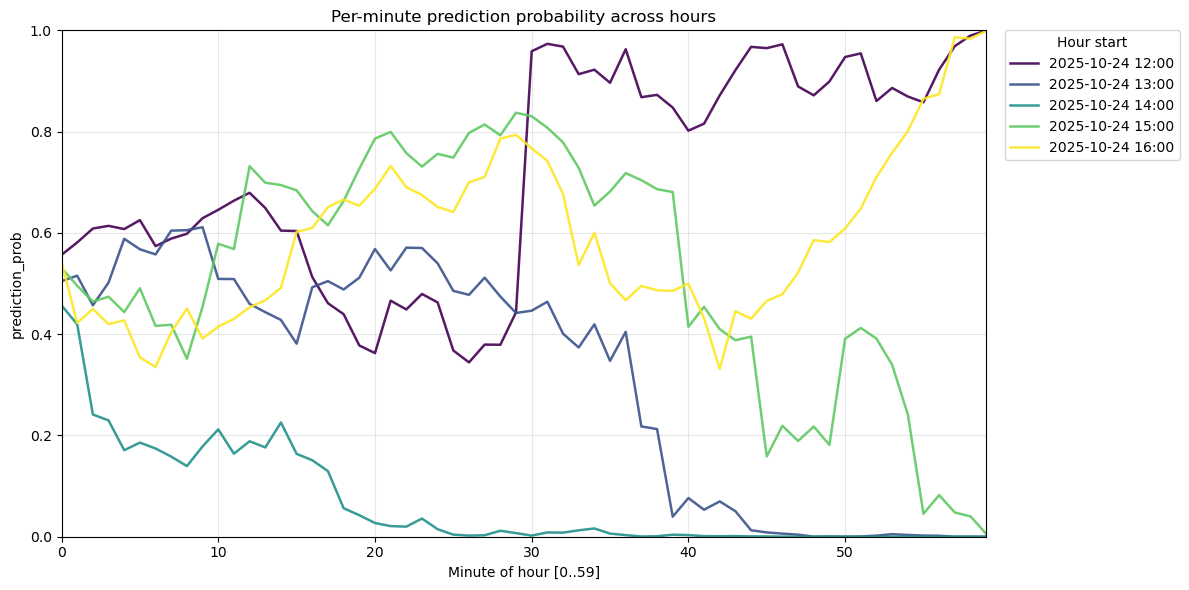

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Per-minute prediction probability across hours'}, xlabel='Minute of hour [0..59]', ylabel='prediction_prob'>,
 DatetimeIndex(['2025-10-24 12:00:00', '2025-10-24 13:00:00',
                '2025-10-24 14:00:00', '2025-10-24 15:00:00',
                '2025-10-24 16:00:00'],
               dtype='datetime64[ns]', name='hour_start', freq=None),
 minute                     0         1         2         3         4   \
 hour_start                                                              
 2025-10-17 19:00:00  0.514273  0.573868  0.607322  0.508787  0.612907   
 2025-10-17 20:00:00  0.507465  0.493612  0.447812  0.472873  0.461120   
 2025-10-17 21:00:00  0.521597  0.550422  0.534702  0.548489  0.583073   
 2025-10-17 22:00:00  0.511650  0.522965  0.556078  0.589100  0.580834   
 2025-10-17 23:00:00  0.481187  0.499248  0.439557  0.438913  0.421552   
 ...                       ...       ...       ...       ...       ...   
 

In [83]:
plot_prediction_prob_across_hours(
    df=series_with_pred,
    time_col="open_time",
    prob_col="prediction_prob",
    n_hours=5,
    require_full_hours=True,  
    select="last",           
    title="Per-minute prediction probability across hours",
)


In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_hour_prob_and_cum_delta(
    df: pd.DataFrame,
    hour_index: int = 0,
    select: str = "last",              # "first" or "last"
    time_col: str = "open_time",
    prob_col: str = "prediction_prob",
    delta_col: str = "delta",
    require_full_hour: bool = True,
    deduplicate_per_minute: bool = True,  # if duplicates per minute exist, keep the last one
    title: str | None = None,
    show: bool = True,
):
    """
    Plot a single hour's per-minute prediction probability (left y-axis)
    and cumulative delta (right y-axis) on the same figure.

    Args:
        df: DataFrame containing at least [time_col, prob_col, delta_col] at minute frequency.
        hour_index: which hour to plot (0-based).
        select: whether hour_index counts from the "first" (earliest) or "last" (most recent) hour.
        time_col: datetime column name.
        prob_col: column with per-minute prediction probability in [0, 1].
        delta_col: column with per-minute delta values.
        require_full_hour: if True, only hours with all minutes 0..59 are allowed.
        deduplicate_per_minute: if multiple rows share the same minute-of-hour, keep the last one.
        title: optional title for the plot.
        show: call plt.show() if True.

    Returns:
        (fig, ax_prob, ax_delta, hour_start, hour_df)
          - hour_start: Timestamp of the hour start
          - hour_df: DataFrame slice used for plotting with columns:
                     [time_col, 'minute', prob_col, delta_col, 'cum_delta']
    """
    if time_col not in df.columns or prob_col not in df.columns or delta_col not in df.columns:
        raise ValueError(f"Expected columns '{time_col}', '{prob_col}', '{delta_col}' in df")

    data = df[[time_col, prob_col, delta_col]].copy()
    data[time_col] = pd.to_datetime(data[time_col], errors="coerce")
    data = data.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)

    # Derive hour start and minute-of-hour
    data["hour_start"] = data[time_col].dt.floor("h")
    data["minute"] = data[time_col].dt.minute

    # Optionally enforce full hours (0..59)
    if require_full_hour:
        coverage = data.groupby("hour_start")["minute"].agg(["min", "max", "count"])
        # full hour means we have 60 points and min==0 and max==59
        full_mask = (coverage["min"] == 0) & (coverage["max"] == 59) & (coverage["count"] >= 60)
        full_hours = coverage.index[full_mask]
        if len(full_hours) == 0:
            raise ValueError("No complete hours found (0..59). Set require_full_hour=False to include partial hours.")
        hours = pd.Index(full_hours)
    else:
        hours = data["hour_start"].drop_duplicates().sort_values()

    # Select the hour by index
    hours = hours.sort_values()
    if select.lower() == "last":
        idx = len(hours) - 1 - hour_index
    elif select.lower() == "first":
        idx = hour_index
    else:
        raise ValueError("select must be 'first' or 'last'")

    if idx < 0 or idx >= len(hours):
        raise IndexError(f"hour_index out of range. Available hours: {len(hours)}")

    hour_start = hours[idx]
    hour_df = data.loc[data["hour_start"] == hour_start, [time_col, "minute", prob_col, delta_col]].copy()

    # Deduplicate per minute if necessary (keep last per minute)
    if deduplicate_per_minute:
        hour_df = hour_df.sort_values(time_col).drop_duplicates(subset=["minute"], keep="last")

    # Reindex minutes to 0..59 for alignment
    minutes = pd.Index(range(60))
    hour_df = hour_df.set_index("minute").reindex(minutes)
    # Forward-fill time for nicer x-tooltip if there are occasional missing minutes
    # (optional: not strictly needed)
    hour_df[time_col] = hour_df[time_col].ffill()

    # Compute cumulative delta (ignoring missing)
    hour_df["cum_delta"] = hour_df[delta_col].fillna(0).cumsum()

    # If require_full_hour, ensure no NaNs remain for prob; otherwise we will mask when plotting
    # Prepare x and y
    x = minutes.to_numpy()
    y_prob = hour_df[prob_col].to_numpy(dtype=float)
    y_cum = hour_df["cum_delta"].to_numpy(dtype=float)

    fig, ax_prob = plt.subplots(figsize=(12, 6))
    ax_delta = ax_prob.twinx()

    # Plot probability (left axis)
    mask_prob = ~np.isnan(y_prob)
    ax_prob.plot(x[mask_prob], y_prob[mask_prob], color="tab:blue", lw=2.0, label="prediction_prob")
    ax_prob.set_ylim(0.0, 1.0)
    ax_prob.set_ylabel("prediction_prob", color="tab:blue")
    ax_prob.tick_params(axis="y", labelcolor="tab:blue")

    # Plot cumulative delta (right axis)
    mask_cum = ~np.isnan(y_cum)
    ax_delta.plot(x[mask_cum], y_cum[mask_cum], color="tab:orange", lw=2.0, label="cum_delta")
    ax_delta.set_ylabel("cumulative delta", color="tab:orange")
    ax_delta.tick_params(axis="y", labelcolor="tab:orange")

    # Labels, grid, title
    ax_prob.set_xlim(0, 59)
    ax_prob.set_xlabel("Minute of hour [0..59]")
    ax_prob.grid(True, alpha=0.3)
    ax_prob.set_title(title or f"Hour {hour_start} — probability (left) vs cumulative delta (right)")

    # Optional reference lines
    ax_prob.axhline(0.5, color="gray", ls="--", lw=1, alpha=0.6)  # neutral prob
    ax_delta.axhline(0.0, color="gray", ls=":", lw=1, alpha=0.6)  # zero delta

    # Legends
    # Place a combined legend on the left axis
    lines = []
    labels = []
    for ax in (ax_prob, ax_delta):
        l, lab = ax.get_legend_handles_labels()
        lines.extend(l)
        labels.extend(lab)
    if lines:
        ax_prob.legend(lines, labels, loc="upper left")

    plt.tight_layout()
    if show:
        plt.show()

    # Return data used
    hour_df = hour_df.reset_index().rename(columns={"index": "minute"})
    return fig, ax_prob, ax_delta, hour_start, hour_df

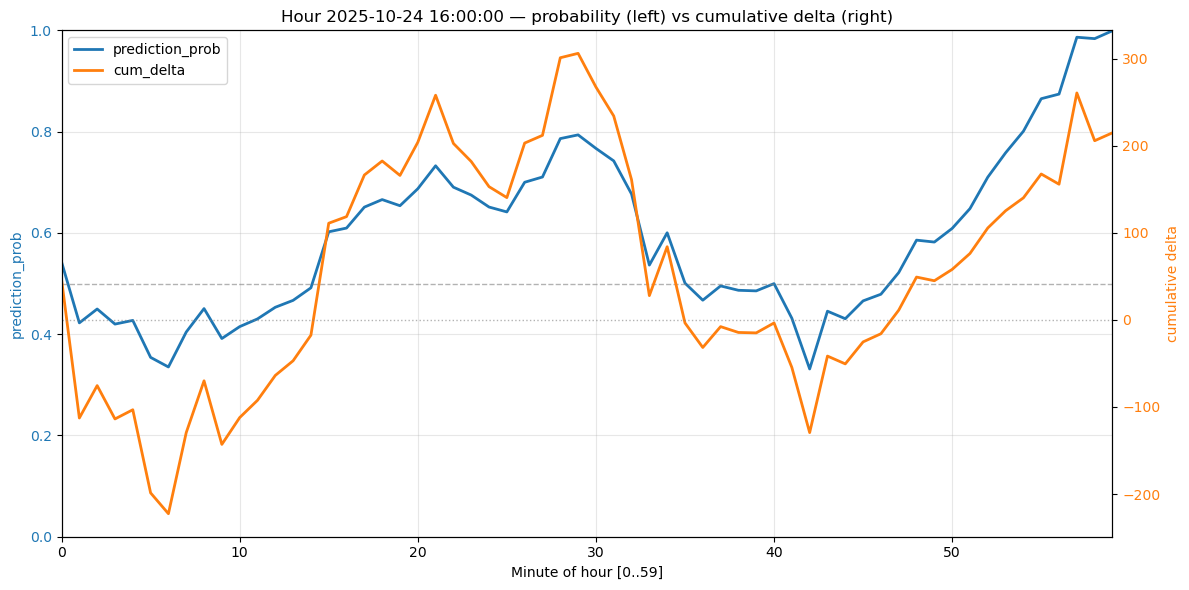

In [85]:
# Plot the most recent hour (hour_index=0 from the last)
fig, ax_prob, ax_delta, hour_start, hour_slice = plot_hour_prob_and_cum_delta(
    series_with_pred,
    hour_index=0,
    select="last",
    time_col="open_time",
    prob_col="prediction_prob",
    delta_col="delta",
    require_full_hour=True,   # set False if you want to allow partial hours
)